# RQ2: Per-Repository Case Studies Analysis

## Imports & Load Dataset

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import percent_meeting_condition, conditional_acceptance_rate, df_column_statistics, chi_squared_test, fishers_exact_test

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

filtered_df = pd.read_csv('data/filtered/pull_request.csv')
related_issue_df = pd.read_csv('data/filtered/related_issue.csv')
repo_df = pd.read_csv('data/filtered/repository.csv')
pr_task_type_df = pd.read_csv('data/filtered/pr_task_type.csv')

## Constants

In [2]:
# AI Agents in the dataset
AGENTS = ["Human", "OpenAI_Codex", "Devin", "Copilot", "Cursor", "Claude_Code"]

AGENT_DISPLAY_NAMES = {
    "Human": "Human",
    "OpenAI_Codex": "OpenAI Codex",
    "Devin": "Devin",
    "Copilot": "Copilot",
    "Cursor": "Cursor",
    "Claude_Code": "Claude Code",
}

# Task types (Conventional Commits)
TASK_TYPE_ORDER = [
    "feat", "fix", "perf", "refactor", "style",
    "docs", "test", "chore", "build", "ci", "revert", "other"
]

# Task type mapping for paper display
TASK_TYPE_DISPLAY = {
    "feat": "New feature",
    "fix": "Bug fix",
    "docs": "Documentation",
    "chore": "Chore",
    "perf": "Performance",
    "refactor": "Refactor",
    "style": "Other*",
    "test": "Other*",
    "build": "Other*",
    "ci": "Other*",
    "revert": "Other*",
    "other": "Other*",
}

# Colors for visualizations
COLOR_MAP = {
    "Human": "#56B4E9",
    "OpenAI_Codex": "#D55E00",
    "Devin": "#009E73",
    "Copilot": "#0072B2",
    "Cursor": "#785EF0",
    "Claude_Code": "#DC267F",
}

OUTCOME_COLORS = {
    "accepted": "#4ECDC4",
    "rejected": "#FF6B6B",
}

## Repository Selection

We select two groups of 50 repositories:
1. **Top 50 by GitHub Stars** (high-visibility projects)
2. **Top 50 by PR Count** (high AI-activity projects)

### Top 50 by GitHub Stars

In [3]:
# Get repos that have PRs in filtered dataset
repos_in_filtered = filtered_df['repo_id'].unique()
repos_available = repo_df[repo_df['id'].isin(repos_in_filtered)].copy()

print(f"Repositories with PRs in filtered dataset: {len(repos_available)}")

# Count PRs per repo
pr_counts = filtered_df.groupby('repo_id').size().reset_index(name='pr_count')
repos_available = repos_available.merge(pr_counts, left_on='id', right_on='repo_id', how='left')

# Sort by stars and get top 50
top_by_stars = repos_available.nlargest(50, "stars")

print(f"\nTop 50 repositories by stars:")
print(f"  Stars range: {top_by_stars["stars"].min():,} to {top_by_stars["stars"].max():,}")
print(f"  PR count range: {top_by_stars['pr_count'].min()} to {top_by_stars['pr_count'].max()}")

Repositories with PRs in filtered dataset: 1054

Top 50 repositories by stars:
  Stars range: 26,945 to 175,171
  PR count range: 1 to 260


In [4]:
# Filter PRs to top 50 by stars
stars_pr_df = filtered_df[filtered_df['repo_id'].isin(top_by_stars['id'])].copy()

print(f"\nPRs in top 50 by stars: {len(stars_pr_df):,}")


PRs in top 50 by stars: 669


### Top 50 by PR Count

In [5]:
# Sort by PR count and get top 50
top_by_prs = repos_available.nlargest(50, 'pr_count')

print(f"Top 50 repositories by PR count:")
print(f"  PR count range: {top_by_prs['pr_count'].min():.0f} to {top_by_prs['pr_count'].max():.0f}")
print(f"  Stars range: {top_by_prs["stars"].min():,} to {top_by_prs["stars"].max():,}")

Top 50 repositories by PR count:
  PR count range: 29 to 343
  Stars range: 116 to 175,171


In [6]:
# Filter PRs to top 50 by PR count
prs_pr_df = filtered_df[filtered_df['repo_id'].isin(top_by_prs['id'])].copy()

print(f"\nPRs in top 50 by PR count: {len(prs_pr_df):,}")


PRs in top 50 by PR count: 3,622


## Acceptance Rate Analysis

In [7]:
def compute_acceptance_stats(pr_df, top_repos):
    """Compute acceptance rate statistics for a set of repositories."""
    results = []
    
    for _, repo in top_repos.iterrows():
        repo_prs = pr_df[pr_df['repo_id'] == repo['id']]
        total = len(repo_prs)
        accepted = repo_prs['accepted'].sum()
        rejected = repo_prs['rejected'].sum()
        
        acc_rate = (accepted / total * 100) if total > 0 else 0
        
        results.append({
            'repo_name': repo['full_name'],
            'repo_id': repo['id'],
            'total': total,
            'accepted': int(accepted),
            'rejected': int(rejected),
            'acceptance_rate': acc_rate
        })
    
    df = pd.DataFrame(results)
    
    # Aggregate statistics
    total_prs = df['total'].sum()
    total_accepted = df['accepted'].sum()
    overall_rate = total_accepted / total_prs * 100 if total_prs > 0 else 0
    
    # Mean and std of per-repo acceptance rates
    mean_rate = df['acceptance_rate'].mean()
    std_rate = df['acceptance_rate'].std()
    
    return {
        'per_repo_df': df,
        'total_repos': len(df),
        'total_prs': int(total_prs),
        'total_accepted': int(total_accepted),
        'total_rejected': int(df['rejected'].sum()),
        'overall_acceptance_rate': overall_rate,
        'mean_acceptance_rate': mean_rate,
        'std_acceptance_rate': std_rate,
    }

### Acceptance Rates - Top by Stars

In [8]:
stars_stats = compute_acceptance_stats(stars_pr_df, top_by_stars)

print("TOP 50 BY STARS - Acceptance Statistics")
print("="*50)
print(f"Repositories: {stars_stats['total_repos']}")
print(f"Total PRs: {stars_stats['total_prs']:,}")
print(f"Accepted: {stars_stats['total_accepted']:,}")
print(f"Rejected: {stars_stats['total_rejected']:,}")
print(f"")
print(f"Acceptance Rate: {stars_stats['mean_acceptance_rate']:.1f}% ± {stars_stats['std_acceptance_rate']:.1f}%")
print(f"Overall Rate: {stars_stats['overall_acceptance_rate']:.1f}%")

TOP 50 BY STARS - Acceptance Statistics
Repositories: 50
Total PRs: 669
Accepted: 278
Rejected: 391

Acceptance Rate: 51.2% ± 38.0%
Overall Rate: 41.6%


### Acceptance Rates - Top by PRs

In [9]:
prs_stats = compute_acceptance_stats(prs_pr_df, top_by_prs)

print("TOP 50 BY PR COUNT - Acceptance Statistics")
print("="*50)
print(f"Repositories: {prs_stats['total_repos']}")
print(f"Total PRs: {prs_stats['total_prs']:,}")
print(f"Accepted: {prs_stats['total_accepted']:,}")
print(f"Rejected: {prs_stats['total_rejected']:,}")
print(f"")
print(f"Acceptance Rate: {prs_stats['mean_acceptance_rate']:.1f}% ± {prs_stats['std_acceptance_rate']:.1f}%")
print(f"Overall Rate: {prs_stats['overall_acceptance_rate']:.1f}%")

TOP 50 BY PR COUNT - Acceptance Statistics
Repositories: 50
Total PRs: 3,622
Accepted: 2,526
Rejected: 1,096

Acceptance Rate: 69.2% ± 22.6%
Overall Rate: 69.7%


## RQ1 Factor Analysis

### Time to Closure

In [10]:
print("Summary statistics for 'days_to_close' in the full PR dataset:")
df_column_statistics(filtered_df, 'days_to_close')

Summary statistics for 'days_to_close' in the full PR dataset:
Accepted PR Statistics for 'days_to_close':
Mean = 3.006649204110417
Median = 1.0
Standard Deviation = 5.940535313404627
Min = 1.0
Max = 68.0

Rejected PR Statistics for 'days_to_close':
Mean = 6.89420884632923
Median = 2.0
Standard Deviation = 11.115630156810978
Min = 1.0
Max = 148.0


In [11]:
print("\n\nSummary statistics for 'days_to_close' in the Stars Group:")
df_column_statistics(stars_pr_df, 'days_to_close')



Summary statistics for 'days_to_close' in the Stars Group:
Accepted PR Statistics for 'days_to_close':
Mean = 3.9892086330935252
Median = 1.0
Standard Deviation = 7.070293685631483
Min = 1.0
Max = 51.0

Rejected PR Statistics for 'days_to_close':
Mean = 7.391304347826087
Median = 9.0
Standard Deviation = 7.000939577012577
Min = 1.0
Max = 56.0


In [12]:
print("\n\nSummary statistics for 'days_to_close' in the PRs Group:")
df_column_statistics(prs_pr_df, 'days_to_close')



Summary statistics for 'days_to_close' in the PRs Group:
Accepted PR Statistics for 'days_to_close':
Mean = 2.365795724465558
Median = 1.0
Standard Deviation = 4.607871214449038
Min = 1.0
Max = 66.0

Rejected PR Statistics for 'days_to_close':
Mean = 6.053832116788321
Median = 2.0
Standard Deviation = 9.610678227180502
Min = 1.0
Max = 148.0


In [13]:
def compare_metric_medians_per_repo(pr_df, metric_column):
    """Compare a metric between accepted and rejected PRs per repository."""
    total_count = 0
    count_A = 0
    count_B = 0
    tie = 0
    differences = []

    for repo in pr_df['repo_id'].unique():
        repo_prs = pr_df[pr_df['repo_id'] == repo]

        accepted_prs = repo_prs[repo_prs['accepted']]
        rejected_prs = repo_prs[repo_prs['rejected']]

        if len(accepted_prs) > 0 and len(rejected_prs) > 0:
            total_count += 1

            median_accepted = accepted_prs[metric_column].median()
            median_rejected = rejected_prs[metric_column].median()

            differences.append(median_rejected - median_accepted)

            if median_accepted < median_rejected:
                count_A += 1
            elif median_rejected < median_accepted:
                count_B += 1
            else:
                tie += 1

    print(
        f"Repositories with both accepted and rejected PRs: {total_count}")
    print(
        f"  Accepted PRs have lower {metric_column} in: {count_A} repos ({(count_A/total_count)*100:.2f}%)")
    print(
        f"  Rejected PRs have lower {metric_column} in: {count_B} repos ({(count_B/total_count)*100:.2f}%)")
    print(f"  Ties: {tie} repos ({(tie/total_count)*100:.2f}%)")
    print(f"  Median difference (rejected - accepted): {np.median(differences):.2f} {metric_column}")
    print(
        f"  Mean difference (rejected - accepted): {np.mean(differences):.2f} {metric_column}")


print("Expected Result from RQ1: Median days to close will be lower in accepted PRs than rejected PRs in most repositories.\n")
print("Stars Group:")
compare_metric_medians_per_repo(stars_pr_df, 'days_to_close')

print("\nPRs Group:")
compare_metric_medians_per_repo(prs_pr_df, 'days_to_close')

Expected Result from RQ1: Median days to close will be lower in accepted PRs than rejected PRs in most repositories.

Stars Group:
Repositories with both accepted and rejected PRs: 25
  Accepted PRs have lower days_to_close in: 10 repos (40.00%)
  Rejected PRs have lower days_to_close in: 9 repos (36.00%)
  Ties: 6 repos (24.00%)
  Median difference (rejected - accepted): 0.00 days_to_close
  Mean difference (rejected - accepted): 2.82 days_to_close

PRs Group:
Repositories with both accepted and rejected PRs: 47
  Accepted PRs have lower days_to_close in: 22 repos (46.81%)
  Rejected PRs have lower days_to_close in: 4 repos (8.51%)
  Ties: 21 repos (44.68%)
  Median difference (rejected - accepted): 0.00 days_to_close
  Mean difference (rejected - accepted): 1.37 days_to_close


### Related Issue Analysis

In [14]:
def compute_related_issue_stats(pr_df):
    """Compute acceptance rates by related issue presence."""
    with_issue = pr_df[pr_df['related_issue']]
    without_issue = pr_df[~pr_df['related_issue']]
    
    total_with = len(with_issue)
    total_without = len(without_issue)
    
    acc_with = with_issue['accepted'].sum()
    acc_without = without_issue['accepted'].sum()
    
    rate_with = (acc_with / total_with * 100) if total_with > 0 else 0
    rate_without = (acc_without / total_without * 100) if total_without > 0 else 0
    
    return {
        'with_issue': {'total': total_with, 'accepted': int(acc_with), 'rate': rate_with},
        'without_issue': {'total': total_without, 'accepted': int(acc_without), 'rate': rate_without},
        'effect': rate_with - rate_without
    }

In [15]:
# Related issue analysis for Stars set
stars_issue = compute_related_issue_stats(stars_pr_df)

print("TOP 50 BY STARS - Related Issue Analysis")
print("="*50)
print(f"With related issue:    {stars_issue['with_issue']['total']:,} PRs, {stars_issue['with_issue']['rate']:.1f}% acceptance")
print(f"Without related issue: {stars_issue['without_issue']['total']:,} PRs, {stars_issue['without_issue']['rate']:.1f}% acceptance")
print(f"Effect: {stars_issue['effect']:+.1f}%")

TOP 50 BY STARS - Related Issue Analysis
With related issue:    337 PRs, 41.2% acceptance
Without related issue: 332 PRs, 41.9% acceptance
Effect: -0.6%


In [16]:
# Related issue analysis for PRs set
prs_issue = compute_related_issue_stats(prs_pr_df)

print("TOP 50 BY PR COUNT - Related Issue Analysis")
print("="*50)
print(f"With related issue:    {prs_issue['with_issue']['total']:,} PRs, {prs_issue['with_issue']['rate']:.1f}% acceptance")
print(f"Without related issue: {prs_issue['without_issue']['total']:,} PRs, {prs_issue['without_issue']['rate']:.1f}% acceptance")
print(f"Effect: {prs_issue['effect']:+.1f}%")

TOP 50 BY PR COUNT - Related Issue Analysis
With related issue:    799 PRs, 60.1% acceptance
Without related issue: 2,823 PRs, 72.5% acceptance
Effect: -12.4%


In [17]:
def compare_acceptance_rate_bool_col(pr_df, bool_column):
    """Compare PR acceptance rate between boolean column values per repository."""
    total_count = 0
    count_A = 0
    count_B = 0
    tie = 0

    for repo in pr_df['repo_id'].unique():
        repo_prs = pr_df[pr_df['repo_id'] == repo]

        with_bool = repo_prs[repo_prs[bool_column]]
        without_bool = repo_prs[~repo_prs[bool_column]]

        # Only consider repos that have PRs in both categories and also both accepted and rejected PRs
        if len(with_bool) > 0 and len(without_bool) > 0:
            total_count += 1

            if with_bool['accepted'].mean() > without_bool['accepted'].mean():
                count_A += 1
            elif without_bool['accepted'].mean() > with_bool['accepted'].mean():
                count_B += 1
            else:
                tie += 1

    print(
        f"Repositories that have PRs both True and False for {bool_column}: {total_count}")
    print(
        f"  PR Acceptance Rate is higher with {bool_column} in: {count_A} repos ({(count_A/total_count)*100:.2f}%)")
    print(
        f"  PR Acceptance Rate is higher without {bool_column} in: {count_B} repos ({(count_B/total_count)*100:.2f}%)")
    print(f"  Ties: {tie} repos ({(tie/total_count)*100:.2f}%)")

print("Expected Result from RQ1: Acceptance rate will be lower in PRs with related issues in most repositories.\n")

print("Stars Group - Related Issue Presence:")
compare_acceptance_rate_bool_col(stars_pr_df, 'related_issue')

print("\nPRs Group - Related Issue Presence:")
compare_acceptance_rate_bool_col(prs_pr_df, 'related_issue')

Expected Result from RQ1: Acceptance rate will be lower in PRs with related issues in most repositories.

Stars Group - Related Issue Presence:
Repositories that have PRs both True and False for related_issue: 17
  PR Acceptance Rate is higher with related_issue in: 8 repos (47.06%)
  PR Acceptance Rate is higher without related_issue in: 8 repos (47.06%)
  Ties: 1 repos (5.88%)

PRs Group - Related Issue Presence:
Repositories that have PRs both True and False for related_issue: 31
  PR Acceptance Rate is higher with related_issue in: 15 repos (48.39%)
  PR Acceptance Rate is higher without related_issue in: 16 repos (51.61%)
  Ties: 0 repos (0.00%)


#### Open vs Closed Related Issues

In [18]:
print("Acceptance rates based on presence of open related issue in all PRs with related issues:")
conditional_acceptance_rate(filtered_df[filtered_df['related_issue']], 'has_open_related_issue')

print("\nAcceptance rates based on presence of open related issue in Stars Group PRs with related issues:")
conditional_acceptance_rate(stars_pr_df[stars_pr_df['related_issue']], 'has_open_related_issue')

print("\nAcceptance rates based on presence of open related issue in PRs Group PRs with related issues:")
conditional_acceptance_rate(prs_pr_df[prs_pr_df['related_issue']], 'has_open_related_issue')

Acceptance rates based on presence of open related issue in all PRs with related issues:
Acceptance rate for PRs with has_open_related_issue: 4.57516339869281 (14/306)
Acceptance rate for PRs without has_open_related_issue: 74.22940879231935 (1469/1979)

Acceptance rates based on presence of open related issue in Stars Group PRs with related issues:
Acceptance rate for PRs with has_open_related_issue: 2.564102564102564 (1/39)
Acceptance rate for PRs without has_open_related_issue: 46.308724832214764 (138/298)

Acceptance rates based on presence of open related issue in PRs Group PRs with related issues:
Acceptance rate for PRs with has_open_related_issue: 7.317073170731707 (6/82)
Acceptance rate for PRs without has_open_related_issue: 66.10878661087865 (474/717)


### Reviews

In [19]:
print("Review Presence in full PR dataset:")
percent_meeting_condition(filtered_df, 'has_review')

print("\nReview Presence in Stars Group:")
percent_meeting_condition(stars_pr_df, 'has_review')

print("\nReview Presence in PRs Group:")
percent_meeting_condition(prs_pr_df, 'has_review')

Review Presence in full PR dataset:
Percentage of PRs with has_review: 66.34% (4747/7156)

Review Presence in Stars Group:
Percentage of PRs with has_review: 53.36% (357/669)

Review Presence in PRs Group:
Percentage of PRs with has_review: 65.24% (2363/3622)


In [20]:
print("Acceptance rates based on presence of review for all PRs:")
conditional_acceptance_rate(filtered_df, 'has_review')

print("\nAcceptance rates based on presence of review for Stars Group:")
conditional_acceptance_rate(stars_pr_df, 'has_review')

print("\nAcceptance rates based on presence of review for PRs Group:")
conditional_acceptance_rate(prs_pr_df, 'has_review')

Acceptance rates based on presence of review for all PRs:
Acceptance rate for PRs with has_review: 81.79903096692648 (3883/4747)
Acceptance rate for PRs without has_review: 44.831880448318806 (1080/2409)

Acceptance rates based on presence of review for Stars Group:
Acceptance rate for PRs with has_review: 73.38935574229691 (262/357)
Acceptance rate for PRs without has_review: 5.128205128205128 (16/312)

Acceptance rates based on presence of review for PRs Group:
Acceptance rate for PRs with has_review: 84.0880236986881 (1987/2363)
Acceptance rate for PRs without has_review: 42.811755361397935 (539/1259)


In [21]:
print("Chi-squared test for presence of review in all PRs:")
chi_squared_test(filtered_df, 'has_review')

Chi-squared test for presence of review in all PRs:
Chi-squared Test for 'has_review' vs 'accepted'

Contingency Table:
accepted    False  True 
has_review              
False        1329   1080
True          864   3883

Chi-squared statistic: 1025.7462
P-value: 0.000000000000000
Degrees of freedom: 1
N: 7156
Cramér's V: 0.3786
Summary: $\chi^2$ = 1025.75, $p$ < 0.001, Cramér's V = 0.379


In [22]:
print("\nChi-squared test for presence of review in Stars Group:")
chi_squared_test(stars_pr_df, 'has_review')


Chi-squared test for presence of review in Stars Group:
Chi-squared Test for 'has_review' vs 'accepted'

Contingency Table:
accepted    False  True 
has_review              
False         296     16
True           95    262

Chi-squared statistic: 316.6247
P-value: 0.000000000000000
Degrees of freedom: 1
N: 669
Cramér's V: 0.6880
Summary: $\chi^2$ = 316.62, $p$ < 0.001, Cramér's V = 0.688


In [23]:
print("\nChi-squared test for presence of review in PRs Group:")
chi_squared_test(prs_pr_df, 'has_review')


Chi-squared test for presence of review in PRs Group:
Chi-squared Test for 'has_review' vs 'accepted'

Contingency Table:
accepted    False  True 
has_review              
False         720    539
True          376   1987

Chi-squared statistic: 661.1697
P-value: 0.000000000000000
Degrees of freedom: 1
N: 3622
Cramér's V: 0.4273
Summary: $\chi^2$ = 661.17, $p$ < 0.001, Cramér's V = 0.427


In [24]:
print("Summary statistics for 'num_reviews' where reviews are present in full PR dataset:")
df_column_statistics(filtered_df[filtered_df['has_review']], 'num_reviews')

Summary statistics for 'num_reviews' where reviews are present in full PR dataset:
Accepted PR Statistics for 'num_reviews':
Mean = 3.793716198815349
Median = 2.0
Standard Deviation = 5.035366080021163
Min = 1
Max = 30

Rejected PR Statistics for 'num_reviews':
Mean = 3.4895833333333335
Median = 2.0
Standard Deviation = 4.710372451587742
Min = 1
Max = 30


In [25]:
print("\n\nSummary statistics for 'num_reviews' where reviews are present in Stars Group:")
df_column_statistics(stars_pr_df[stars_pr_df['has_review']], 'num_reviews')



Summary statistics for 'num_reviews' where reviews are present in Stars Group:
Accepted PR Statistics for 'num_reviews':
Mean = 3.9923664122137406
Median = 3.0
Standard Deviation = 4.092786258709409
Min = 1
Max = 30

Rejected PR Statistics for 'num_reviews':
Mean = 3.4947368421052634
Median = 2.0
Standard Deviation = 4.965570148341106
Min = 1
Max = 30


In [26]:
print("\n\nSummary statistics for 'num_reviews' where reviews are present in PRs Group:")
df_column_statistics(prs_pr_df[prs_pr_df['has_review']], 'num_reviews')



Summary statistics for 'num_reviews' where reviews are present in PRs Group:
Accepted PR Statistics for 'num_reviews':
Mean = 3.1852038248616004
Median = 2.0
Standard Deviation = 4.042563385689418
Min = 1
Max = 30

Rejected PR Statistics for 'num_reviews':
Mean = 3.047872340425532
Median = 1.0
Standard Deviation = 4.138643351912102
Min = 1
Max = 30


In [27]:
print("Expected Result from RQ1: Acceptance rate will be higher in PRs with reviews in most repositories.\n")

print("Stars Group - Review Presence:")
compare_acceptance_rate_bool_col(stars_pr_df, 'has_review')

print("\nPRs Group - Review Presence:")
compare_acceptance_rate_bool_col(prs_pr_df, 'has_review')

Expected Result from RQ1: Acceptance rate will be higher in PRs with reviews in most repositories.

Stars Group - Review Presence:
Repositories that have PRs both True and False for has_review: 17
  PR Acceptance Rate is higher with has_review in: 13 repos (76.47%)
  PR Acceptance Rate is higher without has_review in: 2 repos (11.76%)
  Ties: 2 repos (11.76%)

PRs Group - Review Presence:
Repositories that have PRs both True and False for has_review: 44
  PR Acceptance Rate is higher with has_review in: 36 repos (81.82%)
  PR Acceptance Rate is higher without has_review in: 8 repos (18.18%)
  Ties: 0 repos (0.00%)


### Comments

In [28]:
print("Comment Presence in full PR dataset:")
percent_meeting_condition(filtered_df, 'has_comment')

print("\nComment Presence in Stars Group:")
percent_meeting_condition(stars_pr_df, 'has_comment')

print("\nComment Presence in PRs Group:")
percent_meeting_condition(prs_pr_df, 'has_comment')

Comment Presence in full PR dataset:
Percentage of PRs with has_comment: 85.63% (6128/7156)

Comment Presence in Stars Group:
Percentage of PRs with has_comment: 93.42% (625/669)

Comment Presence in PRs Group:
Percentage of PRs with has_comment: 86.61% (3137/3622)


In [29]:
print("Acceptance rates based on presence of comment for all PRs:")
conditional_acceptance_rate(filtered_df, 'has_comment')

print("\nAcceptance rates based on presence of comment for Stars Group:")
conditional_acceptance_rate(stars_pr_df, 'has_comment')

print("\nAcceptance rates based on presence of comment for PRs Group:")
conditional_acceptance_rate(prs_pr_df, 'has_comment')

Acceptance rates based on presence of comment for all PRs:
Acceptance rate for PRs with has_comment: 65.87793733681463 (4037/6128)
Acceptance rate for PRs without has_comment: 90.07782101167315 (926/1028)

Acceptance rates based on presence of comment for Stars Group:
Acceptance rate for PRs with has_comment: 37.92 (237/625)
Acceptance rate for PRs without has_comment: 93.18181818181817 (41/44)

Acceptance rates based on presence of comment for PRs Group:
Acceptance rate for PRs with has_comment: 66.05036659228563 (2072/3137)
Acceptance rate for PRs without has_comment: 93.6082474226804 (454/485)


In [30]:
print("Chi-squared test for presence of comment in all PRs:")
chi_squared_test(filtered_df, 'has_comment')

Chi-squared test for presence of comment in all PRs:
Chi-squared Test for 'has_comment' vs 'accepted'

Contingency Table:
accepted     False  True 
has_comment              
False          102    926
True          2091   4037

Chi-squared statistic: 241.4265
P-value: 0.000000000000000
Degrees of freedom: 1
N: 7156
Cramér's V: 0.1837
Summary: $\chi^2$ = 241.43, $p$ < 0.001, Cramér's V = 0.184


In [31]:
print("\nChi-squared test for presence of comment in Stars Group:")
chi_squared_test(stars_pr_df, 'has_comment')


Chi-squared test for presence of comment in Stars Group:
Chi-squared Test for 'has_comment' vs 'accepted'

Contingency Table:
accepted     False  True 
has_comment              
False            3     41
True           388    237

Chi-squared statistic: 49.4374
P-value: 0.000000000002048
Degrees of freedom: 1
N: 669
Cramér's V: 0.2718
Summary: $\chi^2$ = 49.44, $p$ < 0.001, Cramér's V = 0.272


In [32]:
print("\nChi-squared test for presence of comment in PRs Group:")
chi_squared_test(prs_pr_df, 'has_comment')


Chi-squared test for presence of comment in PRs Group:
Chi-squared Test for 'has_comment' vs 'accepted'

Contingency Table:
accepted     False  True 
has_comment              
False           31    454
True          1065   2072

Chi-squared statistic: 149.8624
P-value: 0.000000000000000
Degrees of freedom: 1
N: 3622
Cramér's V: 0.2034
Summary: $\chi^2$ = 149.86, $p$ < 0.001, Cramér's V = 0.203


In [33]:
print("Expected Result from RQ1: Acceptance rate will be lower in PRs with comments in most repositories.\n")

print("Stars Group - Comment Presence:")
compare_acceptance_rate_bool_col(stars_pr_df, 'has_comment')

print("\nPRs Group - Comment Presence:")
compare_acceptance_rate_bool_col(prs_pr_df, 'has_comment')

Expected Result from RQ1: Acceptance rate will be lower in PRs with comments in most repositories.

Stars Group - Comment Presence:
Repositories that have PRs both True and False for has_comment: 10
  PR Acceptance Rate is higher with has_comment in: 0 repos (0.00%)
  PR Acceptance Rate is higher without has_comment in: 6 repos (60.00%)
  Ties: 4 repos (40.00%)

PRs Group - Comment Presence:
Repositories that have PRs both True and False for has_comment: 17
  PR Acceptance Rate is higher with has_comment in: 3 repos (17.65%)
  PR Acceptance Rate is higher without has_comment in: 14 repos (82.35%)
  Ties: 0 repos (0.00%)


### Commits

In [34]:
print("Summary statistics for 'num_commits' in the full PR dataset:")
df_column_statistics(filtered_df, 'num_commits')

Summary statistics for 'num_commits' in the full PR dataset:
Accepted PR Statistics for 'num_commits':
Mean = 4.6566592786621
Median = 3.0
Standard Deviation = 5.222169037674787
Min = 1
Max = 30

Rejected PR Statistics for 'num_commits':
Mean = 4.362973096215231
Median = 3.0
Standard Deviation = 5.0632438813394955
Min = 0
Max = 30


In [35]:
print("\n\nSummary statistics for 'num_commits' in the Stars Group:")
df_column_statistics(stars_pr_df, 'num_commits')



Summary statistics for 'num_commits' in the Stars Group:
Accepted PR Statistics for 'num_commits':
Mean = 5.122302158273381
Median = 4.0
Standard Deviation = 4.544144376066504
Min = 1
Max = 30

Rejected PR Statistics for 'num_commits':
Mean = 4.585677749360614
Median = 3.0
Standard Deviation = 4.287393504813737
Min = 1
Max = 30


In [36]:
print("\n\nSummary statistics for 'num_commits' in the PRs Group:")
df_column_statistics(prs_pr_df, 'num_commits')



Summary statistics for 'num_commits' in the PRs Group:
Accepted PR Statistics for 'num_commits':
Mean = 4.392319873317498
Median = 3.0
Standard Deviation = 5.080898455106723
Min = 1
Max = 30

Rejected PR Statistics for 'num_commits':
Mean = 4.16514598540146
Median = 3.0
Standard Deviation = 4.826970326793653
Min = 0
Max = 30


In [37]:
print("Expected Result from RQ1: Median number of commits will be tied in accepted PRs and rejected PRs in most repositories.\n")

print("Stars Group - Number of Commits:")
compare_metric_medians_per_repo(stars_pr_df, 'num_commits')
print("\nPRs Group - Number of Commits:")
compare_metric_medians_per_repo(prs_pr_df, 'num_commits')

Expected Result from RQ1: Median number of commits will be tied in accepted PRs and rejected PRs in most repositories.

Stars Group - Number of Commits:
Repositories with both accepted and rejected PRs: 25
  Accepted PRs have lower num_commits in: 7 repos (28.00%)
  Rejected PRs have lower num_commits in: 15 repos (60.00%)
  Ties: 3 repos (12.00%)
  Median difference (rejected - accepted): -0.50 num_commits
  Mean difference (rejected - accepted): -0.20 num_commits

PRs Group - Number of Commits:
Repositories with both accepted and rejected PRs: 47
  Accepted PRs have lower num_commits in: 9 repos (19.15%)
  Rejected PRs have lower num_commits in: 28 repos (59.57%)
  Ties: 10 repos (21.28%)
  Median difference (rejected - accepted): -0.50 num_commits
  Mean difference (rejected - accepted): -0.70 num_commits


### Files Changed

In [38]:
print("Summary statistics for 'num_files_changed' in the full PR dataset:")
df_column_statistics(filtered_df, 'num_files_changed')

Summary statistics for 'num_files_changed' in the full PR dataset:
Accepted PR Statistics for 'num_files_changed':
Mean = 24.99818658069716
Median = 4.0
Standard Deviation = 70.83699374141655
Min = 1.0
Max = 1484.0

Rejected PR Statistics for 'num_files_changed':
Mean = 23.489244851258583
Median = 4.0
Standard Deviation = 70.8000072343478
Min = 0.0
Max = 965.0


In [39]:
print("\n\nSummary statistics for 'num_files_changed' in the Stars Group:")
df_column_statistics(stars_pr_df, 'num_files_changed')



Summary statistics for 'num_files_changed' in the Stars Group:
Accepted PR Statistics for 'num_files_changed':
Mean = 32.381294964028775
Median = 4.0
Standard Deviation = 80.05038085839026
Min = 1.0
Max = 548.0

Rejected PR Statistics for 'num_files_changed':
Mean = 16.342710997442456
Median = 4.0
Standard Deviation = 46.67959738599753
Min = 0.0
Max = 379.0


In [40]:
print("\n\nSummary statistics for 'num_files_changed' in the PRs Group:")
df_column_statistics(prs_pr_df, 'num_files_changed')



Summary statistics for 'num_files_changed' in the PRs Group:
Accepted PR Statistics for 'num_files_changed':
Mean = 27.69477434679335
Median = 3.0
Standard Deviation = 68.02578914296635
Min = 1.0
Max = 616.0

Rejected PR Statistics for 'num_files_changed':
Mean = 21.55045871559633
Median = 4.0
Standard Deviation = 65.97835945388826
Min = 0.0
Max = 965.0


In [41]:
print("Expected Result from RQ1: Median number of files changed will be lower in accepted PRs than rejected PRs in most repositories.\n")

print("Stars Group - Number of Files Changed:")
compare_metric_medians_per_repo(stars_pr_df, 'num_files_changed')
print("\nPRs Group - Number of Files Changed:")
compare_metric_medians_per_repo(prs_pr_df, 'num_files_changed')

Expected Result from RQ1: Median number of files changed will be lower in accepted PRs than rejected PRs in most repositories.

Stars Group - Number of Files Changed:
Repositories with both accepted and rejected PRs: 25
  Accepted PRs have lower num_files_changed in: 9 repos (36.00%)
  Rejected PRs have lower num_files_changed in: 14 repos (56.00%)
  Ties: 2 repos (8.00%)
  Median difference (rejected - accepted): -1.00 num_files_changed
  Mean difference (rejected - accepted): -13.96 num_files_changed

PRs Group - Number of Files Changed:
Repositories with both accepted and rejected PRs: 47
  Accepted PRs have lower num_files_changed in: 21 repos (44.68%)
  Rejected PRs have lower num_files_changed in: 20 repos (42.55%)
  Ties: 6 repos (12.77%)
  Median difference (rejected - accepted): 0.00 num_files_changed
  Mean difference (rejected - accepted): -3.72 num_files_changed


## Task Type Analysis

In [42]:
def compute_task_type_stats(pr_df, task_type_df):
    """Compute acceptance rate by task type."""
    # Merge task types with PRs
    pr_with_task = pr_df.merge(
        task_type_df[['id', 'type']].rename(columns={'id': 'task_pr_id', 'type': 'task_type'}),
        left_on='id',
        right_on='task_pr_id',
        how='left'
    )
    pr_with_task['task_type'] = pr_with_task['task_type'].fillna('other')
    
    # Compute stats per task type
    results = []
    for task_type in TASK_TYPE_ORDER:
        task_prs = pr_with_task[pr_with_task['task_type'] == task_type]
        total = len(task_prs)
        if total > 0:
            accepted = task_prs['accepted'].sum()
            acc_rate = (accepted / total * 100)
            results.append({
                'task_type': task_type,
                'display_name': TASK_TYPE_DISPLAY[task_type],
                'total': total,
                'accepted': int(accepted),
                'rejected': total - int(accepted),
                'acceptance_rate': acc_rate
            })
    
    df = pd.DataFrame(results)
    total_prs = df['total'].sum()
    df['pct_of_set'] = df['total'] / total_prs * 100
    
    return df

In [43]:
def aggregate_task_types_for_paper(task_df):
    """Aggregate task types to match the paper's Table format."""
    paper_mapping = {
        'docs': 'Documentation',
        'chore': 'Chore',
        'feat': 'New feature',
        'fix': 'Bug fix',
        'perf': 'Performance',
        'refactor': 'Refactor',
    }
    other_types = ['style', 'test', 'build', 'ci', 'revert', 'other']
    
    results = []
    
    # Process main categories
    for task_type, display_name in paper_mapping.items():
        row = task_df[task_df['task_type'] == task_type]
        if len(row) > 0:
            results.append({
                'task_type': display_name,
                'total': row['total'].values[0],
                'accepted': row['accepted'].values[0],
                'pct_of_set': row['pct_of_set'].values[0],
                'acceptance_rate': row['acceptance_rate'].values[0]
            })
    
    # Aggregate "Other*"
    other_rows = task_df[task_df['task_type'].isin(other_types)]
    if len(other_rows) > 0:
        total = other_rows['total'].sum()
        accepted = other_rows['accepted'].sum()
        results.append({
            'task_type': 'Other*',
            'total': int(total),
            'accepted': int(accepted),
            'pct_of_set': other_rows['pct_of_set'].sum(),
            'acceptance_rate': (accepted / total * 100) if total > 0 else 0
        })
    
    return pd.DataFrame(results)

In [44]:
# Task type analysis for Stars set
stars_task = compute_task_type_stats(stars_pr_df, pr_task_type_df)
stars_task_paper = aggregate_task_types_for_paper(stars_task)

print("TOP 50 BY STARS - Task Type Analysis")
print("="*60)
print(f"{'Task Type':<15} {'PRs':>6} {'% Set':>8} {'Acc. Rate':>10}")
print("-"*45)
for _, row in stars_task_paper.iterrows():
    print(f"{row['task_type']:<15} {row['total']:>6} {row['pct_of_set']:>7.1f}% {row['acceptance_rate']:>9.1f}%")

TOP 50 BY STARS - Task Type Analysis
Task Type          PRs    % Set  Acc. Rate
---------------------------------------------
Documentation       40     6.0%      70.0%
Chore               26     3.9%      84.6%
New feature        163    24.4%      38.7%
Bug fix            368    55.0%      33.7%
Performance          7     1.0%      42.9%
Refactor            33     4.9%      51.5%
Other*              32     4.8%      65.6%


In [45]:
# Task type analysis for PRs set
prs_task = compute_task_type_stats(prs_pr_df, pr_task_type_df)
prs_task_paper = aggregate_task_types_for_paper(prs_task)

print("TOP 50 BY PR COUNT - Task Type Analysis")
print("="*60)
print(f"{'Task Type':<15} {'PRs':>6} {'% Set':>8} {'Acc. Rate':>10}")
print("-"*45)
for _, row in prs_task_paper.iterrows():
    print(f"{row['task_type']:<15} {row['total']:>6} {row['pct_of_set']:>7.1f}% {row['acceptance_rate']:>9.1f}%")

TOP 50 BY PR COUNT - Task Type Analysis
Task Type          PRs    % Set  Acc. Rate
---------------------------------------------
Documentation      396    10.9%      86.4%
Chore              172     4.7%      88.4%
New feature       1325    36.6%      69.0%
Bug fix           1049    29.0%      60.5%
Performance         27     0.7%      51.9%
Refactor           374    10.3%      74.3%
Other*             279     7.7%      68.5%


### Task Type Table (Paper Format)

In [46]:
# Combined table matching the paper format
print("\nTABLE: Acceptance rates by task type across cohorts")
print("="*80)
print(f"{'Task Type':<16} | {'Stars PRs':>9} | {'% Set':>6} | {'Acc.':>5} | {'PRs PRs':>8} | {'% Set':>6} | {'Acc.':>5}")
print("-"*80)

task_order = ['Documentation', 'Chore', 'New feature', 'Bug fix', 'Performance', 'Refactor', 'Other*']

for task in task_order:
    s_row = stars_task_paper[stars_task_paper['task_type'] == task]
    p_row = prs_task_paper[prs_task_paper['task_type'] == task]
    
    s_total = s_row['total'].values[0] if len(s_row) > 0 else 0
    s_pct = s_row['pct_of_set'].values[0] if len(s_row) > 0 else 0
    s_acc = s_row['acceptance_rate'].values[0] if len(s_row) > 0 else 0
    
    p_total = p_row['total'].values[0] if len(p_row) > 0 else 0
    p_pct = p_row['pct_of_set'].values[0] if len(p_row) > 0 else 0
    p_acc = p_row['acceptance_rate'].values[0] if len(p_row) > 0 else 0
    
    print(f"{task:<16} | {s_total:>9} | {s_pct:>5.1f}% | {s_acc:>4.1f}% | {p_total:>8} | {p_pct:>5.1f}% | {p_acc:>4.1f}%")


TABLE: Acceptance rates by task type across cohorts
Task Type        | Stars PRs |  % Set |  Acc. |  PRs PRs |  % Set |  Acc.
--------------------------------------------------------------------------------
Documentation    |        40 |   6.0% | 70.0% |      396 |  10.9% | 86.4%
Chore            |        26 |   3.9% | 84.6% |      172 |   4.7% | 88.4%
New feature      |       163 |  24.4% | 38.7% |     1325 |  36.6% | 69.0%
Bug fix          |       368 |  55.0% | 33.7% |     1049 |  29.0% | 60.5%
Performance      |         7 |   1.0% | 42.9% |       27 |   0.7% | 51.9%
Refactor         |        33 |   4.9% | 51.5% |      374 |  10.3% | 74.3%
Other*           |        32 |   4.8% | 65.6% |      279 |   7.7% | 68.5%


## Agent Distribution

In [47]:
def compute_agent_distribution(pr_df):
    """Compute agent distribution in the set."""
    results = []
    total_prs = len(pr_df)
    
    for agent in AGENTS:
        if agent == "Human":
            continue  # Skip Human for agentic PR analysis
        agent_prs = pr_df[pr_df['agent'] == agent]
        count = len(agent_prs)
        pct = (count / total_prs * 100) if total_prs > 0 else 0
        
        results.append({
            'agent': AGENT_DISPLAY_NAMES.get(agent, agent),
            'count': count,
            'percentage': pct
        })
    
    return pd.DataFrame(results).sort_values('count', ascending=False)

In [48]:
# Agent distribution for Stars set
stars_agents = compute_agent_distribution(stars_pr_df)

print("TOP 50 BY STARS - Agent Distribution")
print("="*50)
for _, row in stars_agents.iterrows():
    print(f"  {row['agent']:<15}: {row['count']:>4} PRs ({row['percentage']:>5.1f}%)")

TOP 50 BY STARS - Agent Distribution
  Devin          :  320 PRs ( 47.8%)
  Copilot        :  195 PRs ( 29.1%)
  OpenAI Codex   :  106 PRs ( 15.8%)
  Cursor         :   46 PRs (  6.9%)
  Claude Code    :    2 PRs (  0.3%)


In [49]:
# Agent distribution for PRs set
prs_agents = compute_agent_distribution(prs_pr_df)

print("TOP 50 BY PR COUNT - Agent Distribution")
print("="*50)
for _, row in prs_agents.iterrows():
    print(f"  {row['agent']:<15}: {row['count']:>4} PRs ({row['percentage']:>5.1f}%)")

TOP 50 BY PR COUNT - Agent Distribution
  Devin          : 1712 PRs ( 47.3%)
  OpenAI Codex   :  963 PRs ( 26.6%)
  Copilot        :  668 PRs ( 18.4%)
  Cursor         :  249 PRs (  6.9%)
  Claude Code    :   30 PRs (  0.8%)


## Visualizations

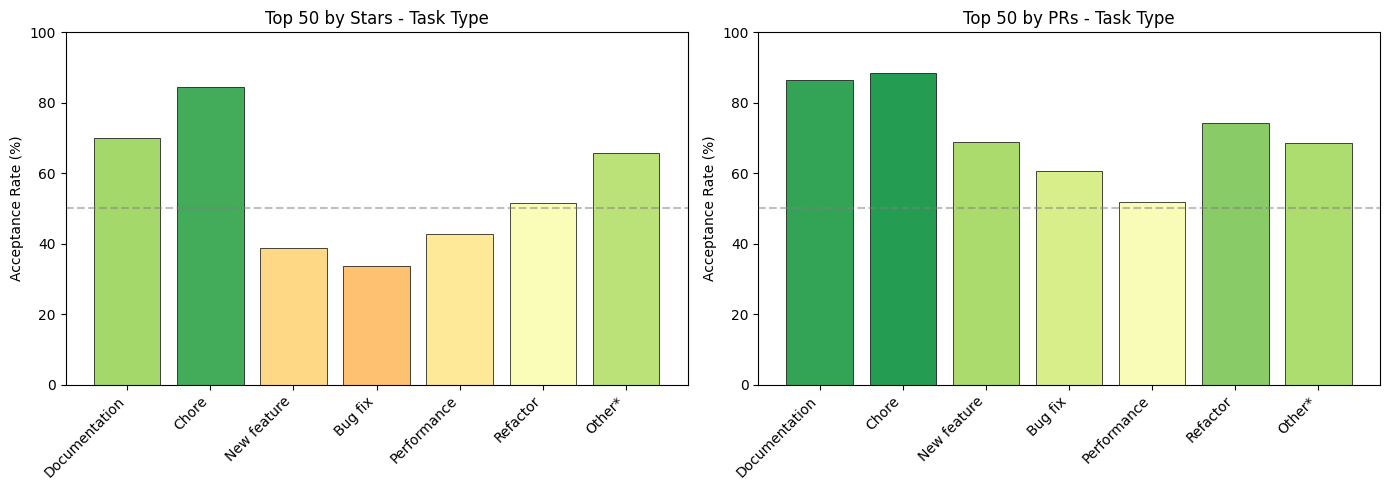

In [50]:
# Task type comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

task_order = ['Documentation', 'Chore', 'New feature', 'Bug fix', 'Performance', 'Refactor', 'Other*']

# Stars set
ax = axes[0]
data = stars_task_paper.set_index('task_type').reindex(task_order).reset_index()
colors = plt.cm.RdYlGn(data['acceptance_rate'] / 100)
bars = ax.bar(range(len(data)), data['acceptance_rate'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(data)))
ax.set_xticklabels(data['task_type'], rotation=45, ha='right')
ax.set_ylabel('Acceptance Rate (%)')
ax.set_title('Top 50 by Stars - Task Type')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

# PRs set
ax = axes[1]
data = prs_task_paper.set_index('task_type').reindex(task_order).reset_index()
colors = plt.cm.RdYlGn(data['acceptance_rate'] / 100)
bars = ax.bar(range(len(data)), data['acceptance_rate'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(data)))
ax.set_xticklabels(data['task_type'], rotation=45, ha='right')
ax.set_ylabel('Acceptance Rate (%)')
ax.set_title('Top 50 by PRs - Task Type')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

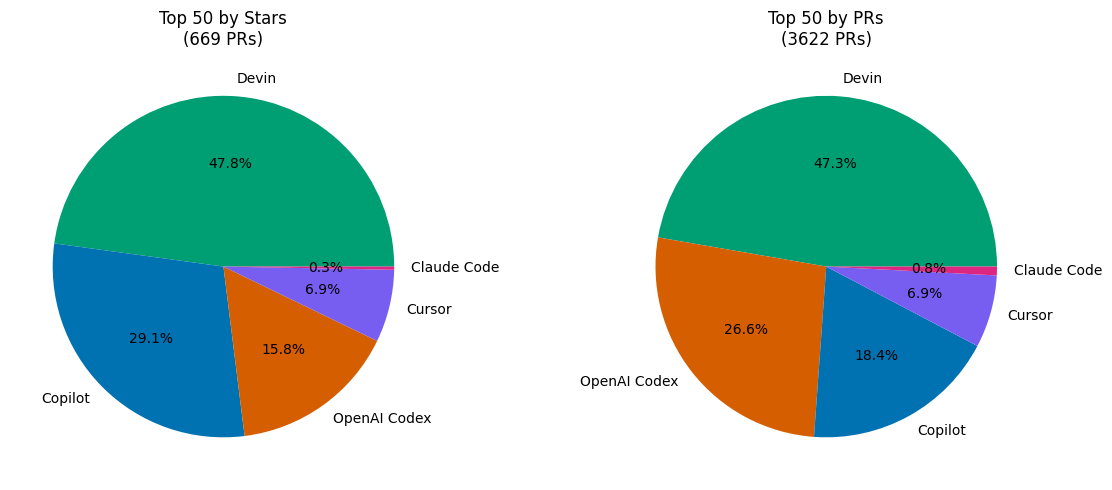

In [51]:
# Agent distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Stars set
ax = axes[0]
agent_colors = [COLOR_MAP.get(a.replace(' ', '_'), '#808080') for a in stars_agents['agent']]
ax.pie(stars_agents['count'], labels=stars_agents['agent'], autopct='%1.1f%%', colors=agent_colors)
ax.set_title(f'Top 50 by Stars\n({len(stars_pr_df)} PRs)')

# PRs set
ax = axes[1]
agent_colors = [COLOR_MAP.get(a.replace(' ', '_'), '#808080') for a in prs_agents['agent']]
ax.pie(prs_agents['count'], labels=prs_agents['agent'], autopct='%1.1f%%', colors=agent_colors)
ax.set_title(f'Top 50 by PRs\n({len(prs_pr_df)} PRs)')

plt.tight_layout()
plt.show()

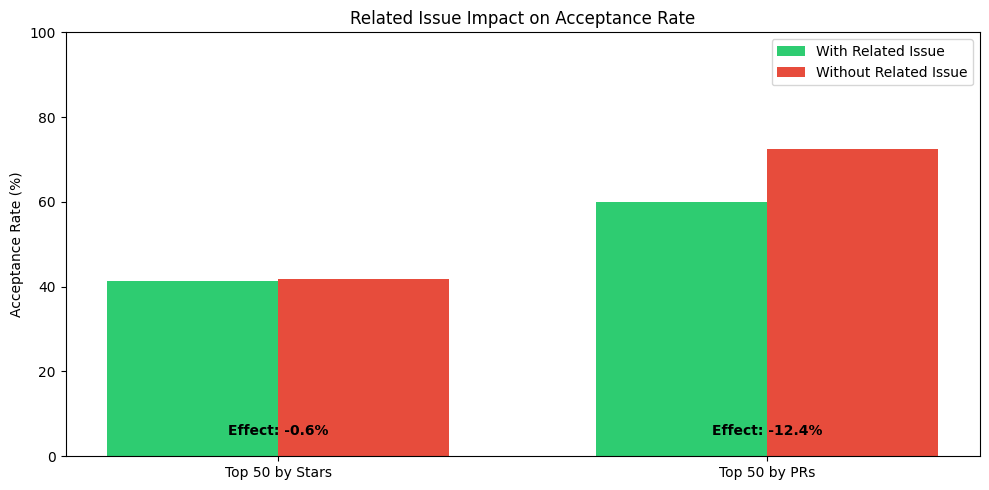

In [52]:
# Related issue impact
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(2)
width = 0.35

# With issue
with_rates = [stars_issue['with_issue']['rate'], prs_issue['with_issue']['rate']]
without_rates = [stars_issue['without_issue']['rate'], prs_issue['without_issue']['rate']]

bars1 = ax.bar(x - width/2, with_rates, width, label='With Related Issue', color='#2ecc71')
bars2 = ax.bar(x + width/2, without_rates, width, label='Without Related Issue', color='#e74c3c')

ax.set_ylabel('Acceptance Rate (%)')
ax.set_title('Related Issue Impact on Acceptance Rate')
ax.set_xticks(x)
ax.set_xticklabels(['Top 50 by Stars', 'Top 50 by PRs'])
ax.legend()
ax.set_ylim(0, 100)

# Add effect labels
for i, (effect, label) in enumerate([(stars_issue['effect'], 'Stars'), (prs_issue['effect'], 'PRs')]):
    ax.annotate(f'Effect: {effect:+.1f}%', xy=(i, 5), ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()